# H3グリッドを活用した建物IDの付番

H3を活用して建物に固有のIDを付与するプロジェクトのための作業ノートブック。

### 使用データ

- OpenStreetMapのデータ（今回は奈良市中心部のデータにて実験）

OSMのウェブサイトからエクスポートした.osmファイルをQGISにて加工し、GPKGとして保存したもの。

### 使用した主なパッケージ

- H3
- GeoPandas


## ID付けの試行

奈良市中心部のデータを用いてID付けを試行。

オープンソースのものを用いているため、

#### データ・パッケージの準備

使用するH3およびGeoPandas、その他のパッケージをimportし、奈良市中心部の建物データをロード。

In [33]:
import h3
import geopandas as gpd
import pandas as pd
import shapely
import os
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
# 建物データをロード
nara_buildings = gpd.read_file(os.path.join('data', 'nara_buildings.gpkg'))

In [3]:
# 件数の確認。今回は6600の建物を対象とする。
print(f'対象建物数：{nara_buildings.shape[0]}件')

対象建物数：6656件


#### ID付け

解像度14（六角形の1辺が1.5m程度）のものを使用してID付け。

In [4]:
# 中心点の緯度・経度を世界測地系で取得
# 正確な中心点を取るために、平面直角座標系に一旦変換した後に中心点を取得、その後世界測地系に戻す。
nara_buildings['centroid_coords'] = nara_buildings.to_crs('EPSG:6674').centroid.to_crs('EPSG:4326')

In [5]:
%%time
# IDを取得
# 今回は解像度14: 1辺約1.5mの六角形を使用し、中点が所在する六角形のIDをそのまま使用。
# 実行時間もノートパソコンで0.2秒程度と、かなり効率よく取得可能。
nara_buildings['id_h3'] = nara_buildings['centroid_coords'].apply(lambda point: h3.latlng_to_cell(point.y, point.x, 14))

CPU times: total: 93.8 ms
Wall time: 260 ms


In [6]:
# 結果を確認（最右列が六角形ID）
nara_buildings[['geometry', 'centroid_coords', 'id_h3']].head(5)

,geometry,centroid_coords,id_h3
0,"MULTIPOLYGON (((135.81538 34.68174, 135.81547 ...",POINT (135.81542 34.68172),8e2e611a02ae6c7
1,"MULTIPOLYGON (((135.81549 34.68163, 135.81554 ...",POINT (135.81552 34.68158),8e2e611a02ae0d7
2,"MULTIPOLYGON (((135.81538 34.68167, 135.81547 ...",POINT (135.81543 34.68161),8e2e611a02ae297
3,"MULTIPOLYGON (((135.81538 34.68155, 135.81548 ...",POINT (135.81543 34.68149),8e2e611a02ae307
4,"MULTIPOLYGON (((135.81539 34.68142, 135.81548 ...",POINT (135.81543 34.68136),8e2e611a02aea77


#### IDの有効性を確認

各IDが割り振られている数を確認し、重複がないことをチェックする。各IDは15桁の数字となる。

In [7]:
# IDごとに重複が無いことを確認。
print(f"各IDに割り当てられた建物数の最大値：{nara_buildings['id_h3'].value_counts().max()}")

# 各IDが割り当てられた建物数のトップ5は以下の通り
print('\n\n念のためトップ5を確認し、以下の通り')
nara_buildings['id_h3'].value_counts().sort_values(ascending = False).head(5)

各IDに割り当てられた建物数の最大値：1


念のためトップ5を確認し、以下の通り


id_h3
8e2e611a02ae6c7    1
8e2e611a02ae0d7    1
8e2e611a02ae297    1
8e2e611a02ae307    1
8e2e611a02aea77    1
Name: count, dtype: int64

## 集計の例

簡単な例として、Res:10 （1辺75mの六角形）のそれぞれのマス目における建物数について表示する。

H3の大きな特徴として、親ノードへの対応が容易であるということが挙げられる。六角形の境界が異なるため正確性にはやや劣るものの、簡易な集計を行うには適していると想定できる。

In [21]:
# 元のデータをコピー
nara_buildings_agg = nara_buildings.copy()

In [22]:
# res09のセルの値を取得
nara_buildings_agg['h3_res10'] = nara_buildings['id_h3'].apply(lambda h: h3.cell_to_parent(h, res=9))

In [23]:
# セルごとに数を集計
building_counts = pd.DataFrame(nara_buildings_agg['h3_res10'].value_counts()).reset_index()

In [24]:
# セルの図形を作成し、GeoDataFrameに変換
building_counts['geometry'] = building_counts['h3_res10'].apply(
    lambda h: shapely.Polygon(list((h3.h3shape_to_geo(h3.LatLngPoly(h3.cell_to_boundary(h)))['coordinates'][0])))
)

building_counts_gdf = gpd.GeoDataFrame(building_counts, crs='EPSG:4326')

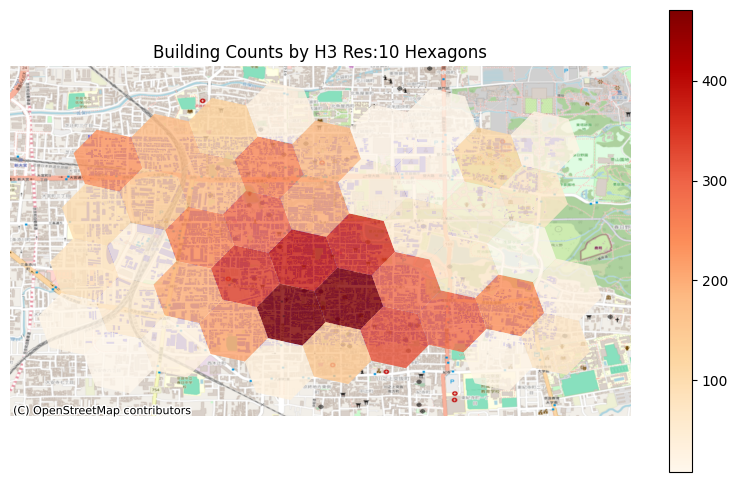

In [36]:
# 地図上に表示
fig, ax = plt.subplots(figsize=(10, 6))
nara_buildings.plot(ax = ax, facecolor = "blue", edgecolor = "none", alpha = 0.5)
building_counts_gdf.plot(column = "count", legend = True, cmap = "OrRd", ax = ax, alpha = 0.8)
plt.title('Building Counts by H3 Res:10 Hexagons')
ctx.add_basemap(ax, crs=building_counts_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=16)
ax.axis('off')
plt.show()

## まとめ

今回のように、H3のデータをIDとして割り当てることで、位置情報の付与および集計を簡単に行うことができる。
他のGISデータを用いることでより強力なID欄となると想定できる。